In [167]:
import pickle
import numpy as np
from tcn_class import TCN
from torch import nn
import torch
import matplotlib.pyplot as plt

In [168]:
WIN_SIZE = 16

In [169]:
with open('data/train.pkl', 'rb') as f:
    train_np = pickle.load(f)

In [170]:
train_np.shape

torch.Size([30, 8001])

In [171]:
def prep_df(df, in_channels, win_size):
    series_len = len(df[0])
    df_size = series_len//win_size
    torch_df = torch.FloatTensor(df_size, in_channels, win_size)
    for i in range(df_size):
        sample = df[:, win_size*i: win_size*(i+1)]
        torch_df[i] = sample
    residual_series = df[:, -win_size:].reshape(1,in_channels, -1)
    return torch_df, residual_series

In [172]:
in_channels = len(train_np)
train, train_resid = prep_df(train_np, in_channels, WIN_SIZE) 
train_size = train.shape[0]

In [173]:
from tcn_autoencoder import TCN_autoencoder 

In [174]:
# model = TCN((in_channels, 24, 16, 24, in_channels), 3)
model = TCN_autoencoder(scale_factor=2, in_channels=in_channels, kernel_size=3, dropout=0) 

In [175]:
epochs_n = 300
learning_rate = 1e-3
criterion = nn.MSELoss()
optim = torch.optim.Adam(model.parameters(), lr=learning_rate)
loss_history = []

In [176]:
for ep in range(epochs_n):
    ep_loss = 0
    pred = model(train)
    loss = criterion(pred, train)

    pred_resid = model(train_resid)
    loss_resid = criterion(pred_resid, train_resid)
    loss = (loss*train_size + loss_resid) / (train_size + 1)

    optim.zero_grad()
    loss.backward()
    optim.step()

    loss_history.append(loss.item())

    if ep % 100 == 0:
        print(loss.item()) 

C:\Users\zmitrovich.nik\Anaconda3\lib\site-packages\torch\nn\functional.py:3609: UserWarning: Default upsampling behavior when mode=linear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
  warnings.warn(


0.42454516887664795
0.18162010610103607
0.18146830797195435


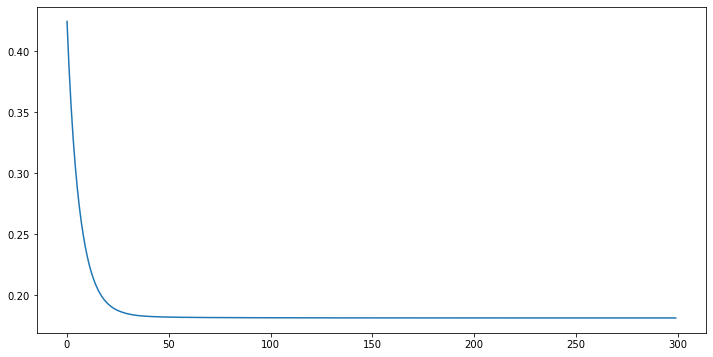

In [177]:
plt.figure(figsize=(12,6))
plt.plot(loss_history[:])

In [178]:
with torch.no_grad():
    train_loss = []
    for sample in train:
        pred = model(sample.reshape(1, in_channels, -1))
        loss = criterion(pred, sample.reshape(1, in_channels, -1))
        train_loss.append(loss.item())

    pred_resid = model(train_resid)
    loss_resid = criterion(pred_resid, train_resid)
    train_loss.append(loss_resid.item())

0.18144810250300372


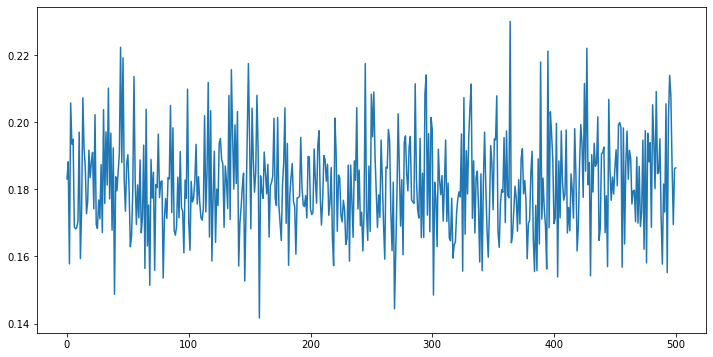

In [179]:
plt.figure(figsize=(12,6))
plt.plot(train_loss)
print(np.mean(train_loss))

In [180]:
with open('data/valid.pkl', 'rb') as f:
    valid_np = pickle.load(f)

In [181]:
valid, valid_resid = prep_df(valid_np, in_channels, WIN_SIZE)
valid_size = valid.shape[0]

In [182]:
with torch.no_grad():
    valid_loss = []
    for sample in valid:
        pred = model(sample.reshape(1, in_channels, -1))
        loss = criterion(pred, sample.reshape(1, in_channels, -1))
        valid_loss.append(loss.item())

    pred_resid = model(valid_resid)
    loss_resid = criterion(pred_resid, valid_resid)
    valid_loss.append(loss_resid.item())

0.1808359453838969


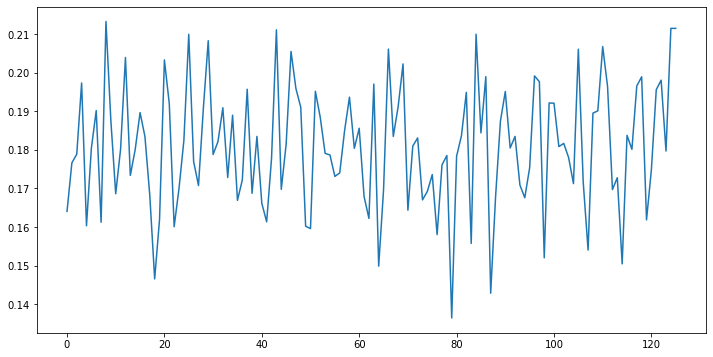

In [183]:
plt.figure(figsize=(12,6))
plt.plot(valid_loss)
print(np.mean(valid_loss))
max_valid_er = np.max(valid_loss)

In [184]:
with open('data/test.pkl', 'rb') as f:
    test_np = pickle.load(f)

In [185]:
test, test_resid = prep_df(test_np, in_channels, WIN_SIZE)

In [186]:
# test = torch.cat((test[100:], test[:100]), 0)

In [187]:
with torch.no_grad():
    test_loss = []
    for sample in test:
        pred = model(sample.reshape(1, in_channels, -1))
        loss = criterion(pred, sample.reshape(1, in_channels, -1))
        test_loss.append(loss.item())
    
    pred_resid = model(test_resid)
    loss_resid = criterion(pred_resid, test_resid)
    test_loss.append(loss_resid.item())

0.1825404209136963


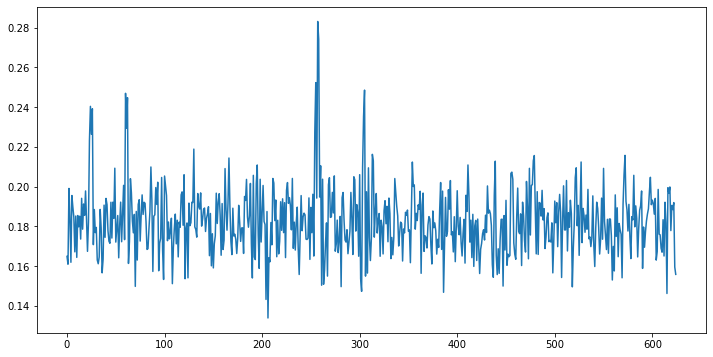

In [188]:
plt.figure(figsize=(12,6))
plt.plot(test_loss)
print(np.mean(test_loss))

In [189]:
with open('data/errors_positions.pkl', 'rb') as f:
    er_pos = pickle.load(f)
er_start = er_pos[0]
er_end = er_pos[1]

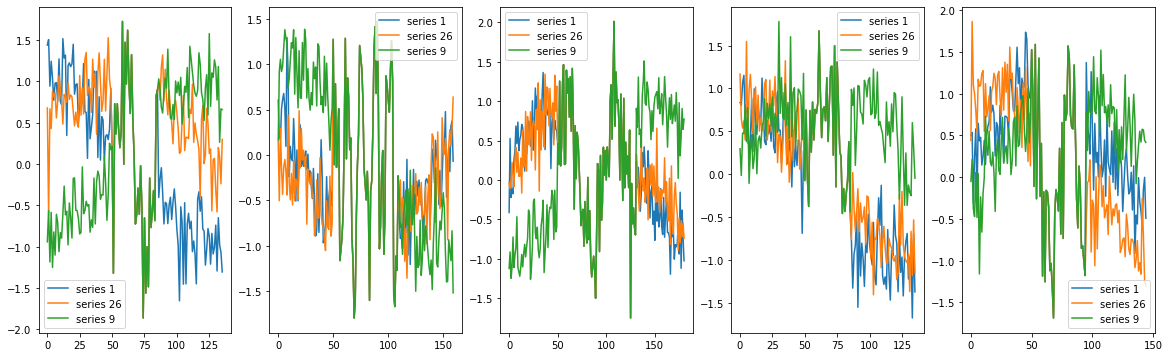

In [190]:
ser_w_er = [1, 26, 9]
fig = plt.figure(figsize=(20,6))
for i in range(5):
    ax = fig.add_subplot(151+i)
    for j in range(3):
        ax.plot(test_np[ser_w_er[j], er_start[i]-50: er_end[i]+50],  label='series {}'.format(ser_w_er[j]))
    plt.legend()

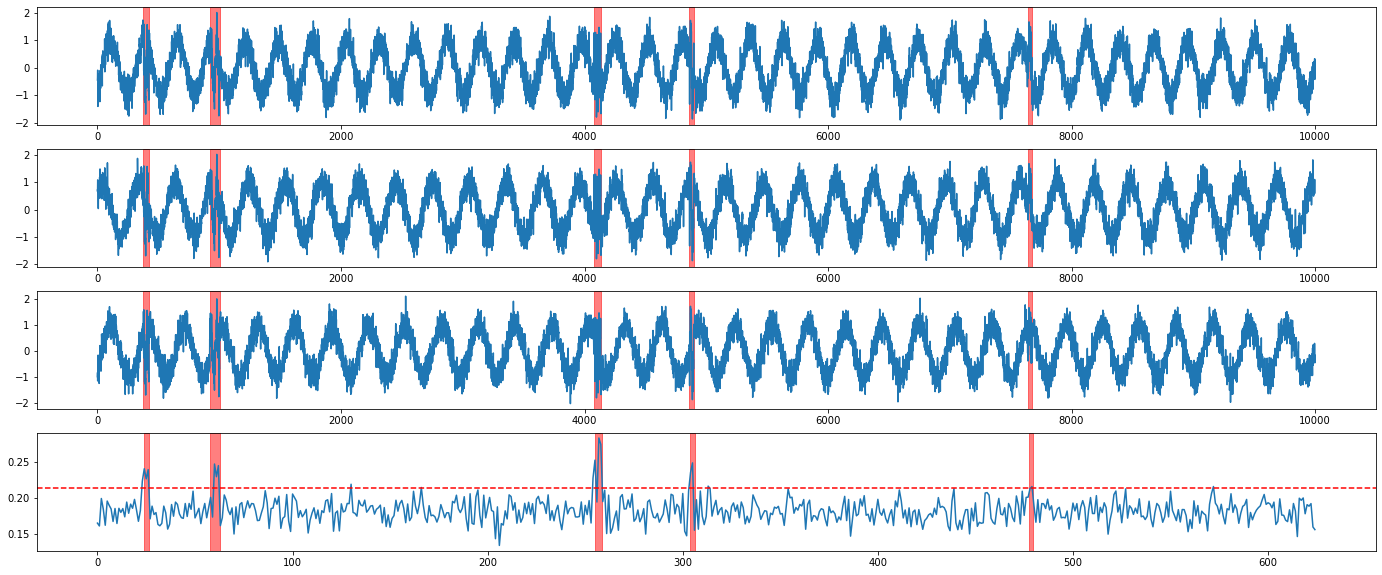

In [191]:
fig = plt.figure(figsize=(24,10))
ax1 = fig.add_subplot(411)
ax1.plot(test_np[ser_w_er[0]])

ax2 = fig.add_subplot(412)
ax2.plot(test_np[ser_w_er[1]])

ax3 = fig.add_subplot(413)
ax3.plot(test_np[ser_w_er[2]])

ax4 = fig.add_subplot(414)
ax4.plot(test_loss)

for start, end in zip(er_start, er_end):
    ax1.axvspan(start, end, color='red', alpha=0.5)
    ax2.axvspan(start, end, color='red', alpha=0.5)
    ax3.axvspan(start, end, color='red', alpha=0.5)
    ax4.axvspan(start/WIN_SIZE, end/WIN_SIZE, color='red', alpha=0.5)

anomaly_border = max_valid_er
ax4.axhline(anomaly_border, color='r', linestyle='--')
